##**This notebook do the proprocessing for the RGB images that going to enter to the Llava**

PNG Converting

In [1]:
import cv2
import os
from PIL import Image

In [2]:
# Paths
src_dir = r"D:\Y4 Research\datasets\open random images\images"
dst_dir = r"D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\PNG Converted"

os.makedirs(dst_dir, exist_ok=True)

# Process images
for filename in os.listdir(src_dir):
    file_path = os.path.join(src_dir, filename)
    try:
        with Image.open(file_path) as img:
            # Convert to RGB
            img_rgb = img.convert("RGB")
            
            # Save as PNG
            base_name = os.path.splitext(filename)[0]
            save_path = os.path.join(dst_dir, base_name + ".png")
            img_rgb.save(save_path, format="PNG")
            
            print(f"Saved: {save_path}")
    except Exception as e:
        print(f"Skipped {filename}: {e}")

Saved: D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\PNG Converted\000_000_003_3045_1.400.png
Saved: D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\PNG Converted\000_000_004_4394_1.400.png
Saved: D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\PNG Converted\000_000_005_9124_2.png
Saved: D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\PNG Converted\000_000_006_5269_4.400.png
Saved: D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\PNG Converted\000_000_007_0701_1.400.png
Saved: D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\PNG Converted\000_000_020_4061_4.400.png
Saved: D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\PNG Converted\000_000_026_5829_4.400.png
Saved: D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\PNG Converted\000_000_027_7945_1.png
Saved: D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\PNG Converted\000_000_035_8156_7.400.png
Saved: D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\PNG Converted\000_000_036_9527_2.400.pn

Adaptive resizing

In [3]:
from tqdm.notebook import tqdm

In [4]:
# Paths
input_dir = r"D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\subset1_Processing\subset1"
output_dir = r"D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\subset1_Processing\resized"

os.makedirs(output_dir, exist_ok=True)

# Parameters
TARGET_SIZE = 640
PADDING_COLOR = (255, 255, 255)  # neutral white

# Resize + pad function
def resize_with_padding(image, target_size=640, pad_color=(255, 255, 255)):
    w, h = image.size

    # Keep aspect ratio
    if w > h:
        new_w = target_size
        new_h = int(h * target_size / w)
    else:
        new_h = target_size
        new_w = int(w * target_size / h)

    image = image.resize((new_w, new_h), Image.LANCZOS)

    # Create square canvas
    new_img = Image.new("RGB", (target_size, target_size), pad_color)

    paste_x = (target_size - new_w) // 2
    paste_y = (target_size - new_h) // 2
    new_img.paste(image, (paste_x, paste_y))

    return new_img

# Get file list
files = os.listdir(input_dir)

# Process images with progress bar
for file in tqdm(files, desc="Resizing images", unit="image"):
    file_path = os.path.join(input_dir, file)

    try:
        with Image.open(file_path) as img:
            img = img.convert("RGB")
            processed_img = resize_with_padding(img, TARGET_SIZE, PADDING_COLOR)

            save_path = os.path.join(output_dir, os.path.splitext(file)[0] + ".png")
            processed_img.save(save_path, format="PNG")

    except Exception as e:
        print(f"✖ Skipped {file}: {e}")


Resizing images:   0%|          | 0/455 [00:00<?, ?image/s]

Denoising 

Separating images (Sharpen vs Denoise): 100%|██████████| 455/455 [00:09<00:00, 45.85it/s]


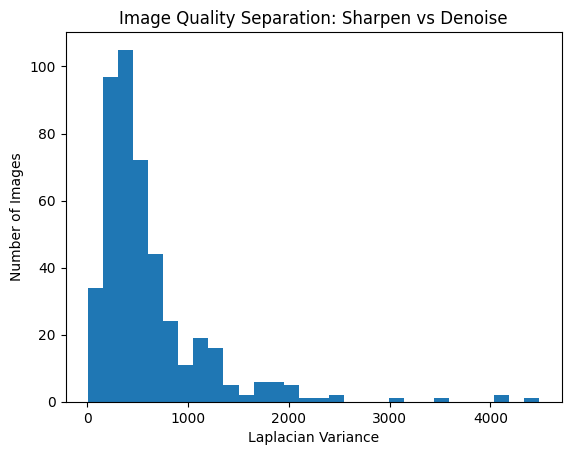

Total images: 455
Images to be sharpened: 5
Images to be denoised: 450


In [5]:
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# PATHS
INPUT_DIR = r"D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\subset1_Processing\resized"
SHARPEN_DIR = r"D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\subset1_Processing\tobe_sharpened"
DENOISE_DIR = r"D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\subset1_Processing\tobe_denoised"

os.makedirs(SHARPEN_DIR, exist_ok=True)
os.makedirs(DENOISE_DIR, exist_ok=True)

# THRESHOLD
LOW_LAPLACIAN_THRESHOLD = 80   # < 80 → blurry → sharpen

laplacian_values = []
categories = []

# Collect image files
image_files = [
    f for f in os.listdir(INPUT_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))
]

# PROCESS IMAGES WITH PROGRESS BAR
for filename in tqdm(image_files, desc="Separating images (Sharpen vs Denoise)"):
    img_path = os.path.join(INPUT_DIR, filename)
    image = cv2.imread(img_path)

    if image is None:
        continue

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()

    laplacian_values.append(lap_var)

    if lap_var < LOW_LAPLACIAN_THRESHOLD:
        categories.append("Sharpen")
        cv2.imwrite(os.path.join(SHARPEN_DIR, filename), image)
    else:
        categories.append("Denoise")
        cv2.imwrite(os.path.join(DENOISE_DIR, filename), image)

# ---------------------------------
# GRAPH SUMMARY
plt.figure()
plt.hist(laplacian_values, bins=30)
plt.xlabel("Laplacian Variance")
plt.ylabel("Number of Images")
plt.title("Image Quality Separation: Sharpen vs Denoise")
plt.show()

# ---------------------------------
# TEXT SUMMARY
print("Total images:", len(laplacian_values))
print("Images to be sharpened:", categories.count("Sharpen"))
print("Images to be denoised:", categories.count("Denoise"))

Denoise level check

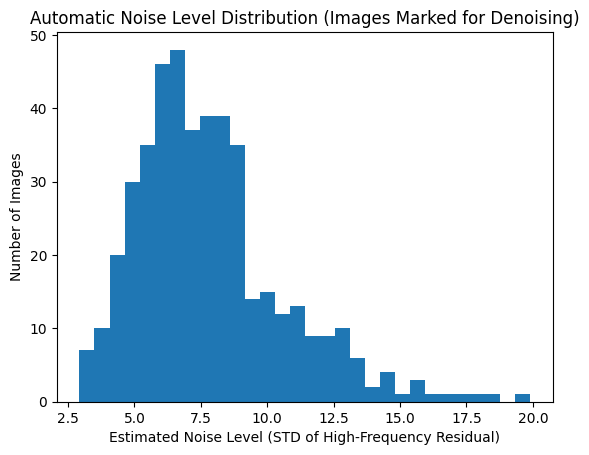

Total images analysed: 450
Mean noise level: 7.8
Min noise level: 2.93
Max noise level: 19.9


In [6]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# PATH
DENOISE_DIR = r"D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\subset1_Processing\tobe_denoised"

# ---------------------------------
# NOISE ESTIMATION FUNCTION
def estimate_noise(gray):
    """
    Estimate noise using high-frequency residuals.
    """
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    noise = gray.astype(np.float32) - blur.astype(np.float32)
    return np.std(noise)

# ---------------------------------
# PROCESS IMAGES
# ---------------------------------
noise_levels = []

for filename in os.listdir(DENOISE_DIR):
    if not filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
        continue

    img_path = os.path.join(DENOISE_DIR, filename)
    image = cv2.imread(img_path)

    if image is None:
        continue

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    noise_score = estimate_noise(gray)
    noise_levels.append(noise_score)

# ---------------------------------
# GRAPH SUMMARY
# ---------------------------------
plt.figure()
plt.hist(noise_levels, bins=30)
plt.xlabel("Estimated Noise Level (STD of High-Frequency Residual)")
plt.ylabel("Number of Images")
plt.title("Automatic Noise Level Distribution (Images Marked for Denoising)")
plt.show()

# ---------------------------------
# TEXT SUMMARY
# ---------------------------------
print("Total images analysed:", len(noise_levels))
print("Mean noise level:", round(np.mean(noise_levels), 2))
print("Min noise level:", round(np.min(noise_levels), 2))
print("Max noise level:", round(np.max(noise_levels), 2))


Adaptive Denoising

In [7]:

# PATHS
# ---------------------------------
INPUT_DIR = r"D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\subset1_Processing\tobe_denoised"
OUTPUT_DIR = r"D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\subset1_Processing\denoised"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------------
# NOISE ESTIMATION
# ---------------------------------
def estimate_noise(gray):
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    residual = gray.astype(np.float32) - blur.astype(np.float32)
    return np.std(residual)

# ---------------------------------
# ADAPTIVE DENOISING
# ---------------------------------
def adaptive_denoise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    noise_level = estimate_noise(gray)

    # Adaptive strength selection
    if noise_level < 10:
        h = 5       # very light
    elif noise_level < 20:
        h = 10      # moderate
    else:
        h = 15      # strong

    denoised = cv2.fastNlMeansDenoisingColored(
        image,
        None,
        h,      # luminance
        h,      # color
        7,
        21
    )

    return denoised, noise_level

# ---------------------------------
# PROCESS WITH PROGRESS BAR
# ---------------------------------
image_files = [
    f for f in os.listdir(INPUT_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))
]

noise_scores = []

for fname in tqdm(image_files, desc="Adaptive denoising"):
    img_path = os.path.join(INPUT_DIR, fname)
    image = cv2.imread(img_path)

    if image is None:
        continue

    denoised_img, noise_val = adaptive_denoise(image)
    noise_scores.append(noise_val)

    cv2.imwrite(os.path.join(OUTPUT_DIR, fname), denoised_img)

# ---------------------------------
# SUMMARY
# ---------------------------------
print("Denoising completed.")
print("Total images processed:", len(noise_scores))
print("Average noise level:", round(np.mean(noise_scores), 2))
print("Max noise level:", round(np.max(noise_scores), 2))


Adaptive denoising: 100%|██████████| 450/450 [06:24<00:00,  1.17it/s]

Denoising completed.
Total images processed: 450
Average noise level: 7.8
Max noise level: 19.9


Adaptive illumination correction

Illumination & Contrast Enhancement: 100%|██████████| 455/455 [00:12<00:00, 37.06it/s]


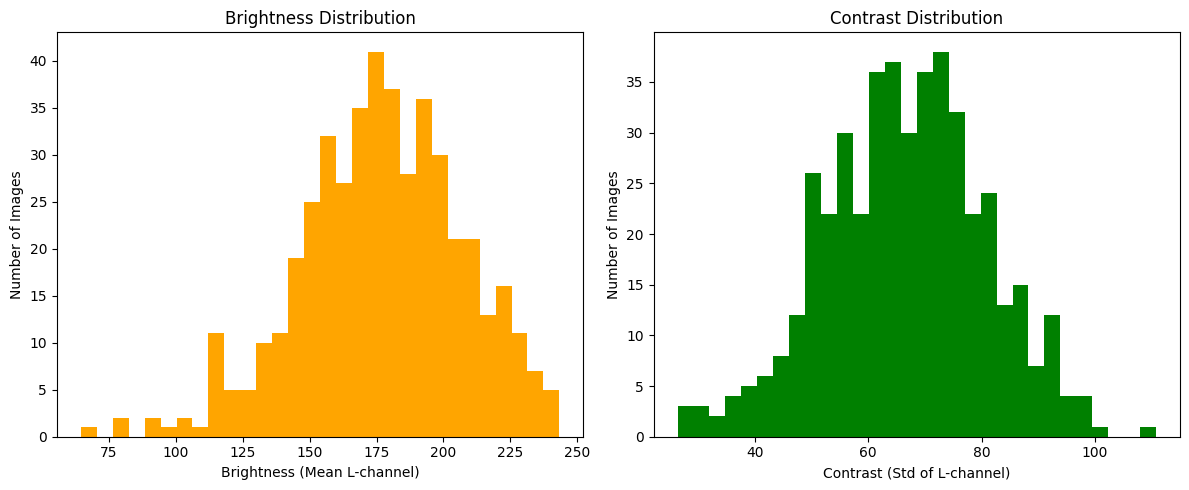

Total images processed: 455
Average brightness: 176.76
Average contrast: 66.59


In [8]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------------------
# PATHS
# -----------------------------
INPUT_DIRS = [
    r"D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\subset1_Processing\denoised",
    r"D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\subset1_Processing\tobe_sharpened"
]
OUTPUT_DIR = r"D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\subset1_Processing\illumination_corrected"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# -----------------------------
# CLAHE parameters
# -----------------------------
TILE_GRID_SIZE = (8, 8)

# -----------------------------
# FUNCTION: Compute brightness & contrast
# -----------------------------
def compute_brightness_contrast(gray):
    mean_val = np.mean(gray)
    std_val = np.std(gray)
    return mean_val, std_val

# -----------------------------
# FUNCTION: Adaptive CLAHE enhancement
# -----------------------------
def adaptive_illumination_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)

    mean, std = compute_brightness_contrast(L)

    # Decide if enhancement is needed
    enhance = False
    if mean < 100 or std < 40:
        enhance = True

    if enhance:
        # Decide CLAHE clipLimit based on severity
        if mean < 80 or std < 35:
            clip_limit = 4.0  # severe
        elif mean < 90 or std < 40:
            clip_limit = 3.0  # moderate
        else:
            clip_limit = 2.0  # slight
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=TILE_GRID_SIZE)
        L = clahe.apply(L)

    lab_merged = cv2.merge([L, A, B])
    enhanced = cv2.cvtColor(lab_merged, cv2.COLOR_LAB2BGR)
    return enhanced, mean, std, enhance

# -----------------------------
# PROCESS IMAGES WITH PROGRESS BAR
# -----------------------------
brightness_list = []
contrast_list = []

all_files = []
for folder in INPUT_DIRS:
    all_files += [os.path.join(folder, f) for f in os.listdir(folder)
                  if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))]

for img_path in tqdm(all_files, desc="Illumination & Contrast Enhancement"):
    img = cv2.imread(img_path)
    if img is None:
        continue

    enhanced_img, mean_val, std_val, enhanced_flag = adaptive_illumination_contrast(img)
    brightness_list.append(mean_val)
    contrast_list.append(std_val)

    # Save enhanced image
    fname = os.path.basename(img_path)
    cv2.imwrite(os.path.join(OUTPUT_DIR, fname), enhanced_img)

# -----------------------------
# GRAPH SUMMARY
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(brightness_list, bins=30, color='orange')
plt.xlabel("Brightness (Mean L-channel)")
plt.ylabel("Number of Images")
plt.title("Brightness Distribution")

plt.subplot(1,2,2)
plt.hist(contrast_list, bins=30, color='green')
plt.xlabel("Contrast (Std of L-channel)")
plt.ylabel("Number of Images")
plt.title("Contrast Distribution")

plt.tight_layout()
plt.show()

# -----------------------------
# TEXT SUMMARY
# -----------------------------
print("Total images processed:", len(brightness_list))
print("Average brightness:", round(np.mean(brightness_list),2))
print("Average contrast:", round(np.mean(contrast_list),2))


Adaptive Sharpening

In [2]:
import cv2
import os
import numpy as np
from tqdm import tqdm

# -----------------------------
# PATHS
# -----------------------------
INPUT_DIR = r"D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\subset1_Processing\illumination_corrected"
OUTPUT_DIR = r"D:\Y4 Research\datasets\Food Images\RGB_Preprocessed\subset1_Processing\sharpened"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# -----------------------------
# FUNCTION: Laplacian variance (edge strength)
# -----------------------------
def laplacian_variance(gray):
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# -----------------------------
# FUNCTION: Adaptive sharpening
# -----------------------------
def adaptive_sharpen(image, low_threshold=100, high_threshold=150):
    """
    Applies sharpening only if image is soft (low Laplacian variance).
    Strength is proportional to softness.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lap_var = laplacian_variance(gray)

    if lap_var < low_threshold:
        # very soft → stronger sharpening
        alpha = 1.0
    elif lap_var < high_threshold:
        # moderately soft → mild sharpening
        alpha = 0.5
    else:
        # already sharp → no sharpening
        return image, lap_var

    # Unsharp mask: sharpened = (1 + alpha)*image - alpha*blur
    blur = cv2.GaussianBlur(image, (3, 3), 0)
    sharpened = cv2.addWeighted(image, 1 + alpha, blur, -alpha, 0)
    return sharpened, lap_var

# -----------------------------
# PROCESS IMAGES WITH PROGRESS BAR
# -----------------------------
laplacian_values = []

image_files = [f for f in os.listdir(INPUT_DIR)
               if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))]

for fname in tqdm(image_files, desc="Adaptive sharpening"):
    img_path = os.path.join(INPUT_DIR, fname)
    img = cv2.imread(img_path)
    if img is None:
        continue

    sharpened_img, lap_var = adaptive_sharpen(img)
    laplacian_values.append(lap_var)

    cv2.imwrite(os.path.join(OUTPUT_DIR, fname), sharpened_img)

# -----------------------------
# TEXT SUMMARY
# -----------------------------
print("Adaptive sharpening completed.")
print("Total images processed:", len(laplacian_values))
print("Average Laplacian variance:", round(np.mean(laplacian_values), 2))
print("Min Laplacian variance:", round(np.min(laplacian_values), 2))
print("Max Laplacian variance:", round(np.max(laplacian_values), 2))


Adaptive sharpening: 100%|██████████| 455/455 [00:11<00:00, 39.98it/s]

Adaptive sharpening completed.
Total images processed: 455
Average Laplacian variance: 552.6
Min Laplacian variance: 9.53
Max Laplacian variance: 4510.94


Preprocessing for Dieatary Images

Adaptive resizing

In [5]:
from PIL import Image
import os
from tqdm import tqdm

# Paths
input_dir = r"D:\Y4 Research\datasets\dietary Images\for llava\Set1"
output_dir = r"D:\Y4 Research\datasets\dietary Images\for llava\resized"
os.makedirs(output_dir, exist_ok=True)

# Parameters
TARGET_SIZE = 640
PADDING_COLOR = (255, 255, 255)

def resize_with_padding(image, target_size=640, pad_color=(255, 255, 255)):
    w, h = image.size
    if w > h:
        new_w = target_size
        new_h = int(h * target_size / w)
    else:
        new_h = target_size
        new_w = int(w * target_size / h)

    image = image.resize((new_w, new_h), Image.LANCZOS)
    new_img = Image.new("RGB", (target_size, target_size), pad_color)
    paste_x = (target_size - new_w) // 2
    paste_y = (target_size - new_h) // 2
    new_img.paste(image, (paste_x, paste_y))
    return new_img

files = os.listdir(input_dir)

for file in tqdm(files, desc="Resizing images", unit="image"):
    file_path = os.path.join(input_dir, file)
    try:
        with Image.open(file_path) as img:
            img = img.convert("RGB")
            processed_img = resize_with_padding(img, TARGET_SIZE, PADDING_COLOR)
            save_path = os.path.join(output_dir, os.path.splitext(file)[0] + ".png")
            processed_img.save(save_path, format="PNG")
    except Exception as e:
        print(f"✖ Skipped {file}: {e}")


Resizing images: 100%|██████████| 100/100 [00:02<00:00, 36.29image/s]


Denoising

Separating images (Sharpen vs Denoise): 100%|██████████| 100/100 [00:02<00:00, 44.67it/s]


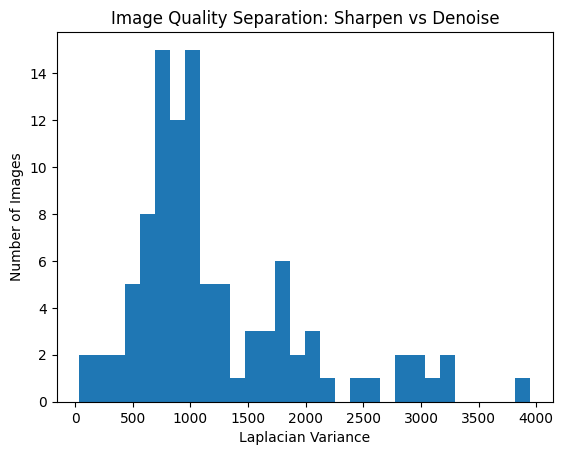

Total images: 100
Images to be sharpened: 2
Images to be denoised: 98


In [7]:
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# PATHS
INPUT_DIR = r"D:\Y4 Research\datasets\dietary Images\for llava\resized"
SHARPEN_DIR = r"D:\Y4 Research\datasets\dietary Images\for llava\not_denoised"
DENOISE_DIR = r"D:\Y4 Research\datasets\dietary Images\for llava\maybe_denoised"

os.makedirs(SHARPEN_DIR, exist_ok=True)
os.makedirs(DENOISE_DIR, exist_ok=True)

# THRESHOLD
LOW_LAPLACIAN_THRESHOLD = 80   # < 80 → blurry → sharpen

laplacian_values = []
categories = []

# Collect image files
image_files = [
    f for f in os.listdir(INPUT_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))
]

# PROCESS IMAGES WITH PROGRESS BAR
for filename in tqdm(image_files, desc="Separating images (Sharpen vs Denoise)"):
    img_path = os.path.join(INPUT_DIR, filename)
    image = cv2.imread(img_path)

    if image is None:
        continue

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lap_var = cv2.Laplacian(gray, cv2.CV_64F).var()

    laplacian_values.append(lap_var)

    if lap_var < LOW_LAPLACIAN_THRESHOLD:
        categories.append("Sharpen")
        cv2.imwrite(os.path.join(SHARPEN_DIR, filename), image)
    else:
        categories.append("Denoise")
        cv2.imwrite(os.path.join(DENOISE_DIR, filename), image)

# ---------------------------------
# GRAPH SUMMARY
plt.figure()
plt.hist(laplacian_values, bins=30)
plt.xlabel("Laplacian Variance")
plt.ylabel("Number of Images")
plt.title("Image Quality Separation: Sharpen vs Denoise")
plt.show()

# ---------------------------------
# TEXT SUMMARY
print("Total images:", len(laplacian_values))
print("Images to be sharpened:", categories.count("Sharpen"))
print("Images to be denoised:", categories.count("Denoise"))

Noise level check

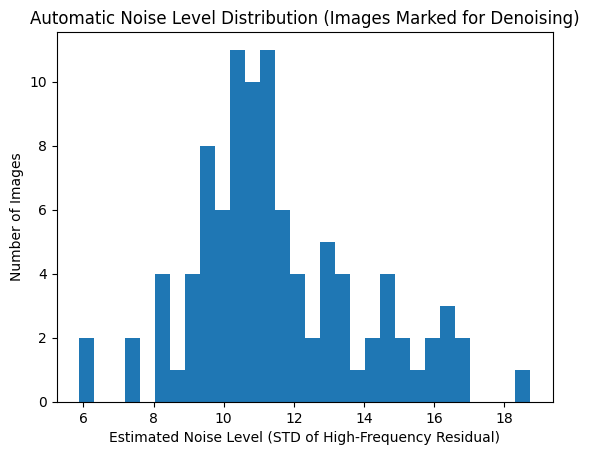

Total images analysed: 98
Mean noise level: 11.52
Min noise level: 5.89
Max noise level: 18.74


In [8]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# PATH
DENOISE_DIR = r"D:\Y4 Research\datasets\dietary Images\for llava\maybe_denoised"

# ---------------------------------
# NOISE ESTIMATION FUNCTION
def estimate_noise(gray):
    """
    Estimate noise using high-frequency residuals.
    """
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    noise = gray.astype(np.float32) - blur.astype(np.float32)
    return np.std(noise)

# ---------------------------------
# PROCESS IMAGES
# ---------------------------------
noise_levels = []

for filename in os.listdir(DENOISE_DIR):
    if not filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
        continue

    img_path = os.path.join(DENOISE_DIR, filename)
    image = cv2.imread(img_path)

    if image is None:
        continue

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    noise_score = estimate_noise(gray)
    noise_levels.append(noise_score)

# ---------------------------------
# GRAPH SUMMARY
# ---------------------------------
plt.figure()
plt.hist(noise_levels, bins=30)
plt.xlabel("Estimated Noise Level (STD of High-Frequency Residual)")
plt.ylabel("Number of Images")
plt.title("Automatic Noise Level Distribution (Images Marked for Denoising)")
plt.show()

# ---------------------------------
# TEXT SUMMARY
# ---------------------------------
print("Total images analysed:", len(noise_levels))
print("Mean noise level:", round(np.mean(noise_levels), 2))
print("Min noise level:", round(np.min(noise_levels), 2))
print("Max noise level:", round(np.max(noise_levels), 2))


Adaptive Denoising

In [9]:

# PATHS
# ---------------------------------
INPUT_DIR = r"D:\Y4 Research\datasets\dietary Images\for llava\maybe_denoised"
OUTPUT_DIR = r"D:\Y4 Research\datasets\dietary Images\for llava\denoised"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------------
# NOISE ESTIMATION
# ---------------------------------
def estimate_noise(gray):
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    residual = gray.astype(np.float32) - blur.astype(np.float32)
    return np.std(residual)

# ---------------------------------
# ADAPTIVE DENOISING
# ---------------------------------
def adaptive_denoise(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    noise_level = estimate_noise(gray)

    # Adaptive strength selection
    if noise_level < 10:
        h = 5       # very light
    elif noise_level < 20:
        h = 10      # moderate
    else:
        h = 15      # strong

    denoised = cv2.fastNlMeansDenoisingColored(
        image,
        None,
        h,      # luminance
        h,      # color
        7,
        21
    )

    return denoised, noise_level

# ---------------------------------
# PROCESS WITH PROGRESS BAR
# ---------------------------------
image_files = [
    f for f in os.listdir(INPUT_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))
]

noise_scores = []

for fname in tqdm(image_files, desc="Adaptive denoising"):
    img_path = os.path.join(INPUT_DIR, fname)
    image = cv2.imread(img_path)

    if image is None:
        continue

    denoised_img, noise_val = adaptive_denoise(image)
    noise_scores.append(noise_val)

    cv2.imwrite(os.path.join(OUTPUT_DIR, fname), denoised_img)

# ---------------------------------
# SUMMARY
# ---------------------------------
print("Denoising completed.")
print("Total images processed:", len(noise_scores))
print("Average noise level:", round(np.mean(noise_scores), 2))
print("Max noise level:", round(np.max(noise_scores), 2))


Adaptive denoising: 100%|██████████| 98/98 [01:23<00:00,  1.18it/s]

Denoising completed.
Total images processed: 98
Average noise level: 11.52
Max noise level: 18.74


Adaptive illumination Correction

Illumination & Contrast Enhancement: 100%|██████████| 100/100 [00:01<00:00, 67.22it/s]


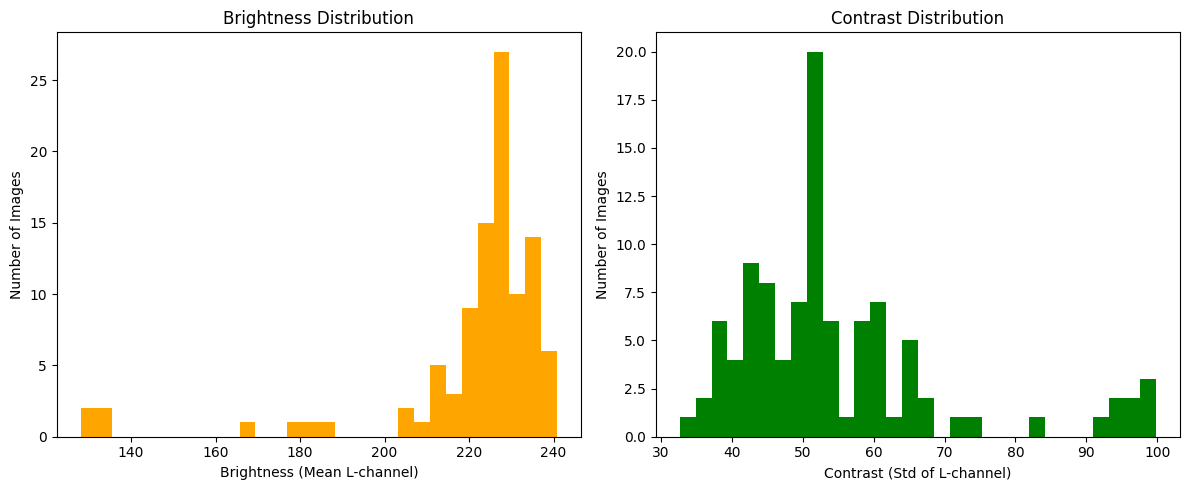

Total images processed: 100
Average brightness: 220.97
Average contrast: 54.88


In [10]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------------------
# PATHS
# -----------------------------
INPUT_DIRS = [
    r"D:\Y4 Research\datasets\dietary Images\for llava\denoised",
    r"D:\Y4 Research\datasets\dietary Images\for llava\not_denoised"
]
OUTPUT_DIR = r"D:\Y4 Research\datasets\dietary Images\for llava\illumination_corrected"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# -----------------------------
# CLAHE parameters
# -----------------------------
TILE_GRID_SIZE = (8, 8)

# -----------------------------
# FUNCTION: Compute brightness & contrast
# -----------------------------
def compute_brightness_contrast(gray):
    mean_val = np.mean(gray)
    std_val = np.std(gray)
    return mean_val, std_val

# -----------------------------
# FUNCTION: Adaptive CLAHE enhancement
# -----------------------------
def adaptive_illumination_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)

    mean, std = compute_brightness_contrast(L)

    # Decide if enhancement is needed
    enhance = False
    if mean < 100 or std < 40:
        enhance = True

    if enhance:
        # Decide CLAHE clipLimit based on severity
        if mean < 80 or std < 35:
            clip_limit = 4.0  # severe
        elif mean < 90 or std < 40:
            clip_limit = 3.0  # moderate
        else:
            clip_limit = 2.0  # slight
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=TILE_GRID_SIZE)
        L = clahe.apply(L)

    lab_merged = cv2.merge([L, A, B])
    enhanced = cv2.cvtColor(lab_merged, cv2.COLOR_LAB2BGR)
    return enhanced, mean, std, enhance

# -----------------------------
# PROCESS IMAGES WITH PROGRESS BAR
# -----------------------------
brightness_list = []
contrast_list = []

all_files = []
for folder in INPUT_DIRS:
    all_files += [os.path.join(folder, f) for f in os.listdir(folder)
                  if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))]

for img_path in tqdm(all_files, desc="Illumination & Contrast Enhancement"):
    img = cv2.imread(img_path)
    if img is None:
        continue

    enhanced_img, mean_val, std_val, enhanced_flag = adaptive_illumination_contrast(img)
    brightness_list.append(mean_val)
    contrast_list.append(std_val)

    # Save enhanced image
    fname = os.path.basename(img_path)
    cv2.imwrite(os.path.join(OUTPUT_DIR, fname), enhanced_img)

# -----------------------------
# GRAPH SUMMARY
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(brightness_list, bins=30, color='orange')
plt.xlabel("Brightness (Mean L-channel)")
plt.ylabel("Number of Images")
plt.title("Brightness Distribution")

plt.subplot(1,2,2)
plt.hist(contrast_list, bins=30, color='green')
plt.xlabel("Contrast (Std of L-channel)")
plt.ylabel("Number of Images")
plt.title("Contrast Distribution")

plt.tight_layout()
plt.show()

# -----------------------------
# TEXT SUMMARY
# -----------------------------
print("Total images processed:", len(brightness_list))
print("Average brightness:", round(np.mean(brightness_list),2))
print("Average contrast:", round(np.mean(contrast_list),2))


Adaptive Sharpening

In [11]:
import cv2
import os
import numpy as np
from tqdm import tqdm

# -----------------------------
# PATHS
# -----------------------------
INPUT_DIR = r"D:\Y4 Research\datasets\dietary Images\for llava\illumination_corrected"
OUTPUT_DIR = r"D:\Y4 Research\datasets\dietary Images\for llava\sharpened"

os.makedirs(OUTPUT_DIR, exist_ok=True)

# -----------------------------
# FUNCTION: Laplacian variance (edge strength)
# -----------------------------
def laplacian_variance(gray):
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# -----------------------------
# FUNCTION: Adaptive sharpening
# -----------------------------
def adaptive_sharpen(image, low_threshold=100, high_threshold=150):
    """
    Applies sharpening only if image is soft (low Laplacian variance).
    Strength is proportional to softness.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lap_var = laplacian_variance(gray)

    if lap_var < low_threshold:
        # very soft → stronger sharpening
        alpha = 1.0
    elif lap_var < high_threshold:
        # moderately soft → mild sharpening
        alpha = 0.5
    else:
        # already sharp → no sharpening
        return image, lap_var

    # Unsharp mask: sharpened = (1 + alpha)*image - alpha*blur
    blur = cv2.GaussianBlur(image, (3, 3), 0)
    sharpened = cv2.addWeighted(image, 1 + alpha, blur, -alpha, 0)
    return sharpened, lap_var

# -----------------------------
# PROCESS IMAGES WITH PROGRESS BAR
# -----------------------------
laplacian_values = []

image_files = [f for f in os.listdir(INPUT_DIR)
               if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"))]

for fname in tqdm(image_files, desc="Adaptive sharpening"):
    img_path = os.path.join(INPUT_DIR, fname)
    img = cv2.imread(img_path)
    if img is None:
        continue

    sharpened_img, lap_var = adaptive_sharpen(img)
    laplacian_values.append(lap_var)

    cv2.imwrite(os.path.join(OUTPUT_DIR, fname), sharpened_img)

# -----------------------------
# TEXT SUMMARY
# -----------------------------
print("Adaptive sharpening completed.")
print("Total images processed:", len(laplacian_values))
print("Average Laplacian variance:", round(np.mean(laplacian_values), 2))
print("Min Laplacian variance:", round(np.min(laplacian_values), 2))
print("Max Laplacian variance:", round(np.max(laplacian_values), 2))


Adaptive sharpening: 100%|██████████| 100/100 [00:01<00:00, 72.25it/s]

Adaptive sharpening completed.
Total images processed: 100
Average Laplacian variance: 1061.37
Min Laplacian variance: 40.31
Max Laplacian variance: 3768.8
